In [2]:
import os, datetime, pickle, math
import numpy as np
import matplotlib.pyplot as plt

import imgaug
from imgaug.augmentables.batches import UnnormalizedBatch
from imgaug import augmenters as iaa

from LazyLuna.utils import *
from LazyLuna.Views import *
from LazyLuna.Mini_LL import *

In [3]:
def plot_function(img, anno):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    anno.plot_all_contour_outlines(ax)
    anno.plot_contour_face(ax, 'scar', 'r')
    anno.plot_contour_face(ax, 'noreflow', 'g')
    plt.show()

In [4]:
bp = '/Users/dietrichhadler/Desktop/Daten/Emidec/Cases'

v     = SAX_LGE_View()
case_paths = [p for p in os.listdir(bp) if p.endswith('.pickle')]
cases = [pickle.load(open(os.path.join(bp, fname), 'rb')) for fname in case_paths]
cases = [v.customize_case(c) for c in cases]        

In [8]:
cases1 = sorted([c for c in cases if c.reader_name=='Gold'], key=lambda c:c.case_name)
cases2 = sorted([c for c in cases if c.reader_name!='Gold'], key=lambda c:c.case_name)
print(len(cases1))
print(len(cases2))

100
100
Case_P039
Case_P039


In [27]:
myo_dices  = []
scar_dices = []
hds        = []
crvals = dict() 
crvaldiffs = dict() 
for cr1 in cases1[0].crs:
    crvals[cr1.name] = []
    crvaldiffs[cr1.name] = []

for c1,c2 in zip(cases1, cases2):
    cat1 = c1.categories[0]
    cat2 = c2.categories[0]
    for cr1, cr2 in zip(c1.crs, c2.crs):
        crvaldiffs[cr1.name].append(cr1.get_val_diff(cr2))
        crvals[cr1.name].append(cr1.get_val())
    #for d in range(cat1.nr_slices):
    ##    anno1, anno2   = cat1.get_anno(d,0), cat2.get_anno(d,0)
    #    myo1,  myo2    = anno1.get_contour('lv_myo'), anno2.get_contour('lv_myo')
    #    scar1, scar2   = anno1.get_contour('scar'),   anno2.get_contour('scar')
    #    myo_dices .append(dice(myo1, myo2))
    #    hds       .append(hausdorff(myo1, myo2))
    #    scar_dices.append(dice(scar1, scar2))
#print(len(myo_dices))
#print(len(hds))
#print(len(scar_dices))

In [30]:
print(crvals.keys())
for crname in ['LVV', 'LVMMASS', 'SCARM', 'SCARF']:
    crs = crvals[crname]
    crdiffs = crvaldiffs[crname]
    print(crname, ': ', np.mean(crs), np.mean(crdiffs), np.std(crdiffs), np.mean(crdiffs)/np.mean(crs))

dict_keys(['LVV', 'LVMV', 'LVMMASS', 'SCARV', 'SCARM', 'SCARF', 'EXCLVOL', 'EXCLMASS', 'NOREFLOWVOL'])
LVV :  113.35604308761569 9.321086883671684 8.128723143600451 0.08222840732423226
LVMMASS :  119.34764180190224 -5.702892305683482 9.174493799614163 -0.04778387087990695
SCARM :  16.66048353068495 10.838661464592038 13.341043819304426 0.6505610383173817
SCARF :  12.5367596985844 8.557466363064018 8.984125823544517 0.6825899649356997


In [21]:
print(crvals.keys())
for crname in ['LVV', 'LVMMASS', 'SCARM', 'SCARF']:
    crs = crvals[crname]
    print(crname, np.mean(crs), np.std(crs))

dict_keys(['LVV', 'LVMV', 'LVMMASS', 'SCARV', 'SCARM', 'SCARF', 'EXCLVOL', 'EXCLMASS', 'NOREFLOWVOL'])
LVV 9.321086883671684 8.128723143600451
LVMMASS -5.702892305683482 9.174493799614163
SCARM 10.838661464592038 13.341043819304426
SCARF 8.557466363064018 8.984125823544517


In [10]:
print(np.mean(myo_dices),  np.std(myo_dices))
print(np.mean(hds),        np.std(hds))
print(np.mean(scar_dices), np.std(scar_dices))

85.18429023413051 6.281366826592484
2.933446472965513 0.935854686175169
56.84934639624343 40.36404696801814


In [149]:
def get_unaugmented_batch(batchsize=8):
    imgs = []
    polys = []
    for _ in range(batchsize):
        i    = np.random.randint(len(cases))
        case = cases[i]
        cat  = case.categories[0]
        d    = np.random.randint(cat.nr_slices)
        img  = cat.get_img(d,0).astype(np.float32)
        anno = cat.get_anno(d,0)
        imgs.append(img)
        imgaug_anno = []
        for c in ['lv_endo', 'lv_myo', 'scar', 'noreflow']:
            cont = anno.get_contour(c)
            if cont.is_empty: continue
            imgaug_mpoly = imgaug.augmentables.polys.MultiPolygon([]).from_shapely(cont, label=c)
            imgaug_cont_polys = [p for p in imgaug_mpoly.geoms]
            imgaug_anno.extend(imgaug_cont_polys)
        polys.append(imgaug_anno)
    return imgs, polys

In [172]:
# custom z score augmenter
def func_images(images, random_state, parents, hooks):
    return [(image-np.mean(image[np.nonzero(image)])) / np.std(image[np.nonzero(image)]) for image in images]
def func_polygons(polygons_on_images, random_state, parents, hooks):
    return polygons_on_images
custom_zscore_augmenter = iaa.Lambda(func_images=func_images, func_polygons=func_polygons)

# order is important 
aug = iaa.Sequential([
    iaa.PadToFixedSize(width=360, height=360, position='center', pad_mode=["linear_ramp"]), #constant, edge, linear_ramp, maximum, median, minimum, reflect, symmetric, wrap
    iaa.Sometimes(0.6, iaa.Affine(rotate = (-180, 180), scale = {"x": (0.8, 1.2), "y": (0.8, 1.2)})),      # rotation and scaling performed quite often
    iaa.Sometimes(0.4, iaa.Affine(translate_percent={"x": (-0.07, 0.07), "y": (-0.07, 0.07)}, shear=(-5, 5))), # translation and shearing occurs, but not as often
    iaa.CropToFixedSize(width=192, height=192, position='center'),
    custom_zscore_augmenter,                                                  # a custom zscore is applied (see above) after cropping, otherwise the means/variances are distorted significantly
    iaa.Sometimes(0.15, iaa.AveragePooling(((1, 2), (1, 2)))),                # average pooling mimics a downsampling of the x or y axis
    iaa.Sometimes(0.15, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.15))), # some noise, 0.2 definitely too high, 0.05 not visible, 0.07 looks good
    iaa.Sometimes(0.15, iaa.GaussianBlur(sigma=(0, 2.0))),
    iaa.Sometimes(0.20, iaa.Multiply((0.7, 1.3))),                             # brightness 
    iaa.Sometimes(0.15, iaa.LinearContrast((0.7, 1.4))),                      # contrast augmentation
], random_order=False)                                                        # apply augmenters in random order

# order is important 
no_aug = iaa.Sequential([
    iaa.PadToFixedSize(width=360, height=360, position='center', pad_mode=["linear_ramp"]), #constant, edge, linear_ramp, maximum, median, minimum, reflect, symmetric, wrap
    iaa.CropToFixedSize(width=192, height=192, position='center'),
    custom_zscore_augmenter,                                                  # a custom zscore is applied (see above) after cropping, 
], random_order=False)  

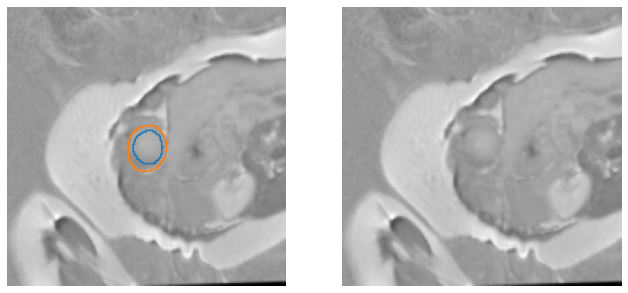

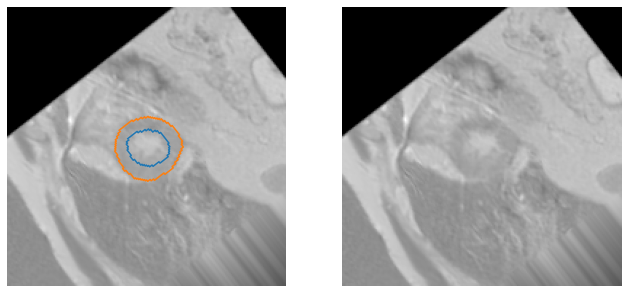

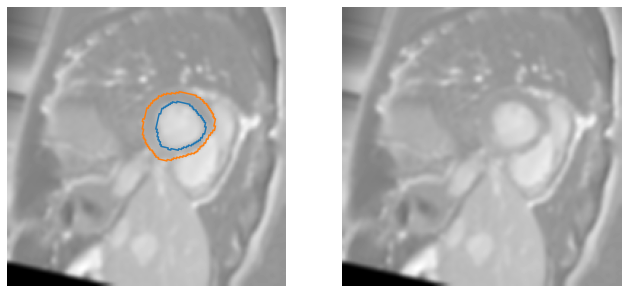

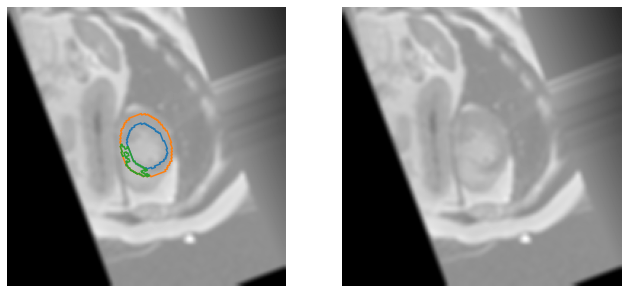

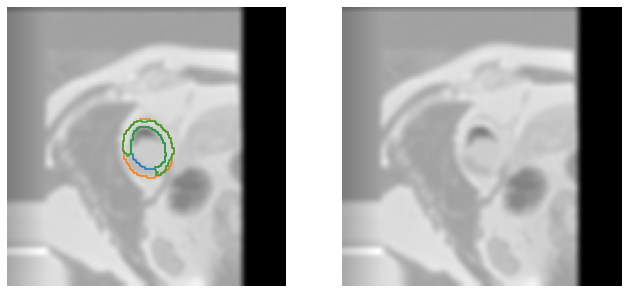

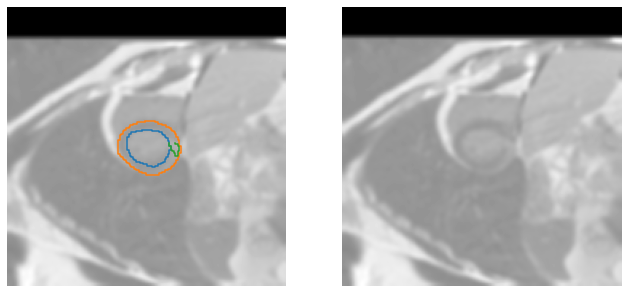

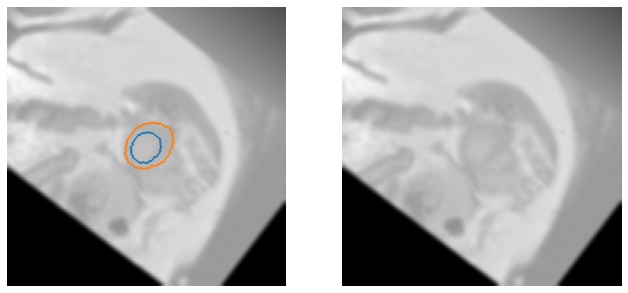

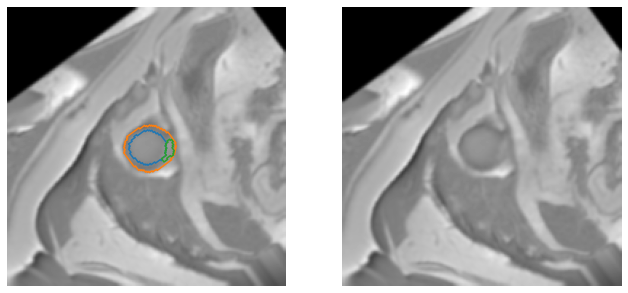

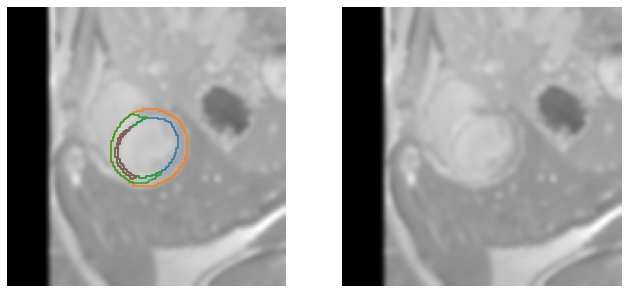

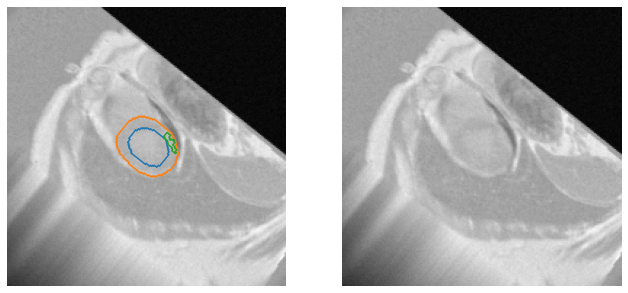

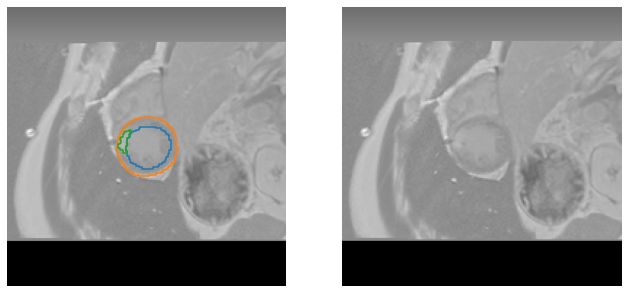

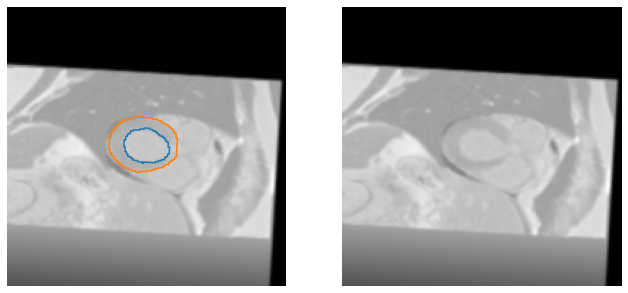

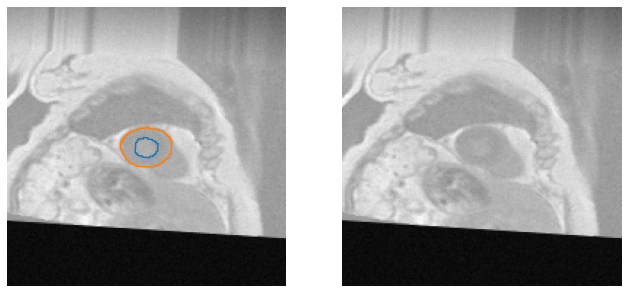

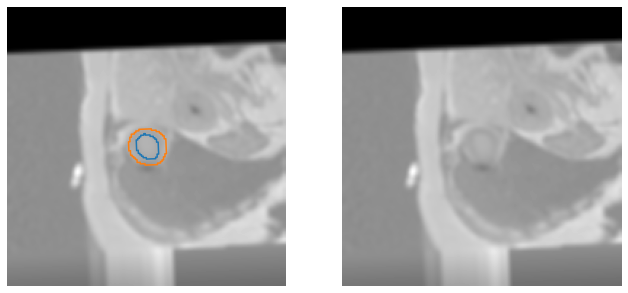

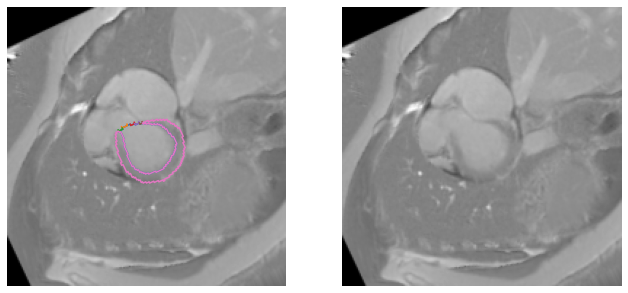

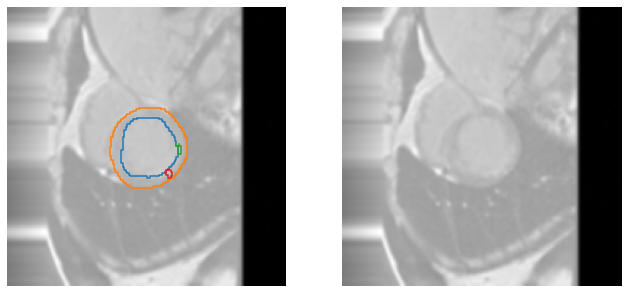

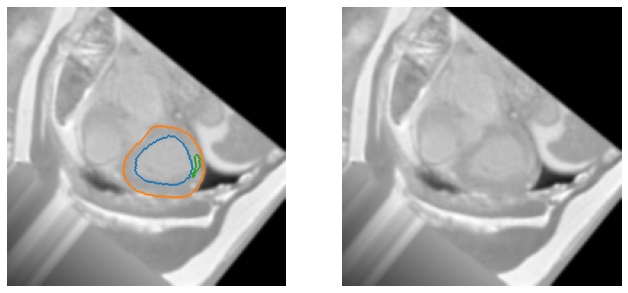

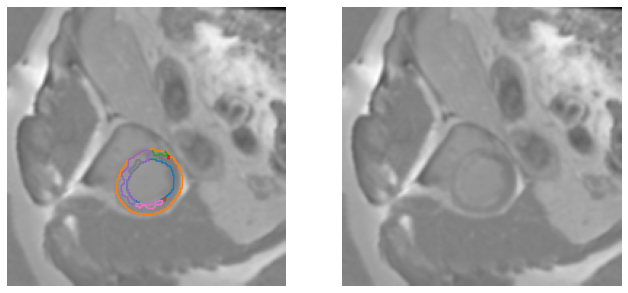

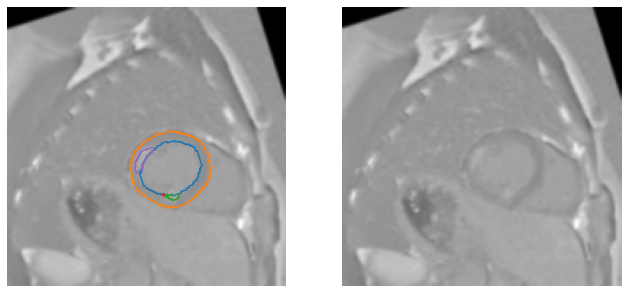

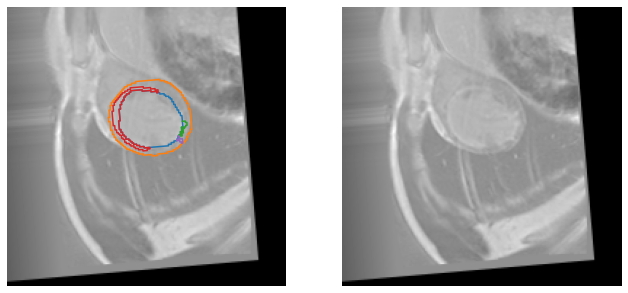

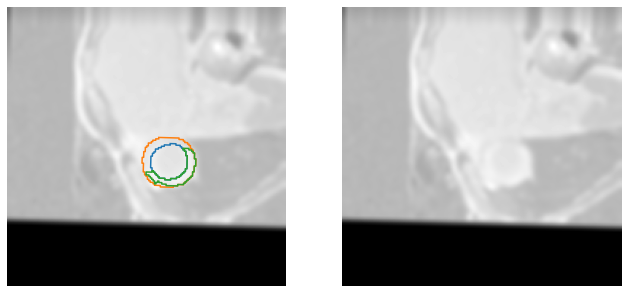

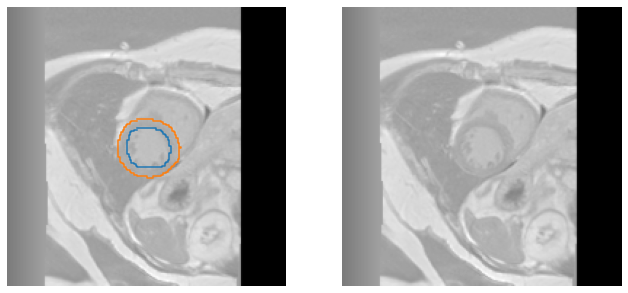

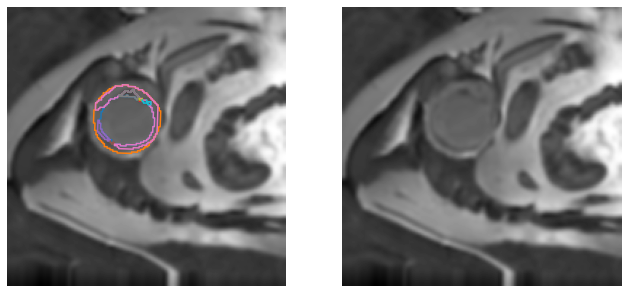

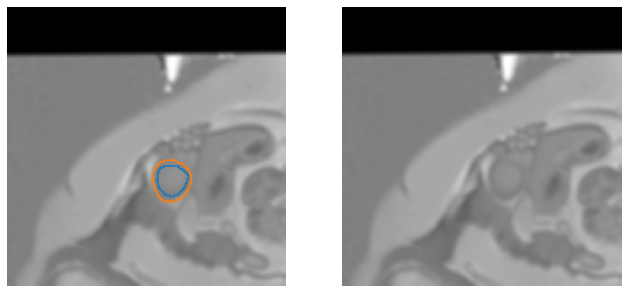

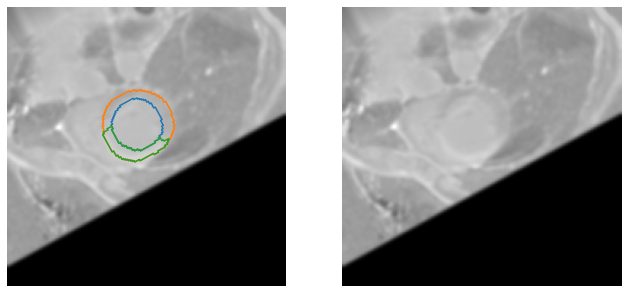

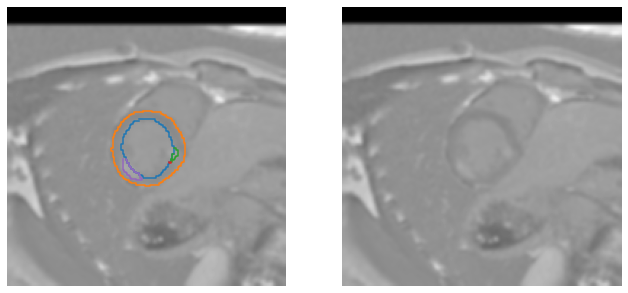

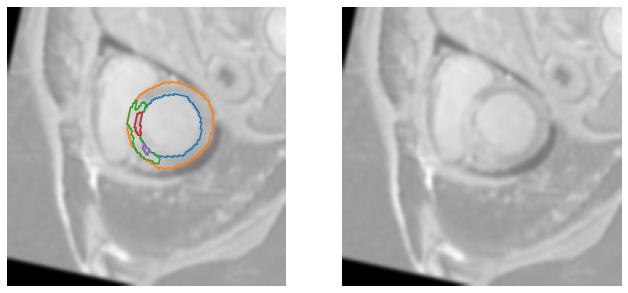

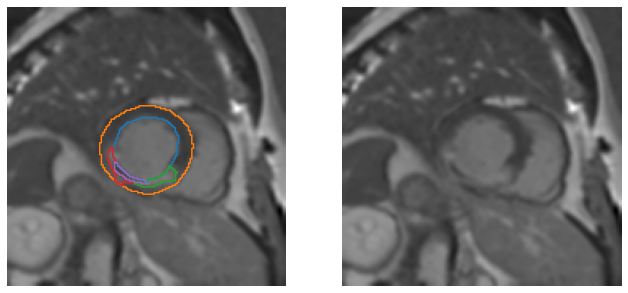

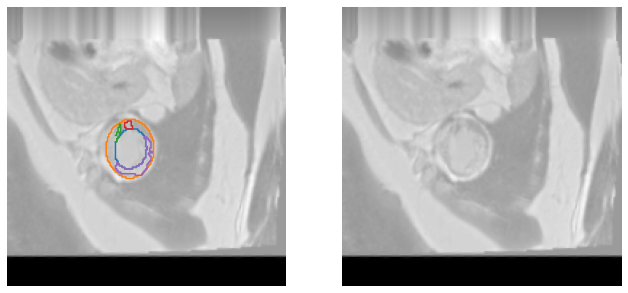

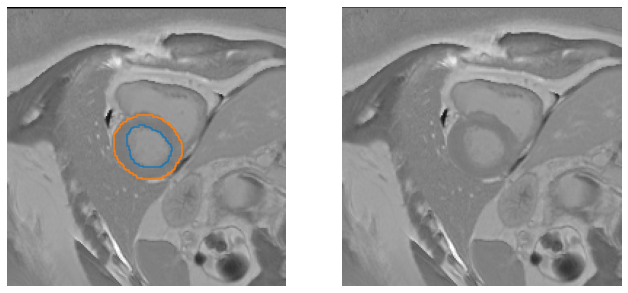

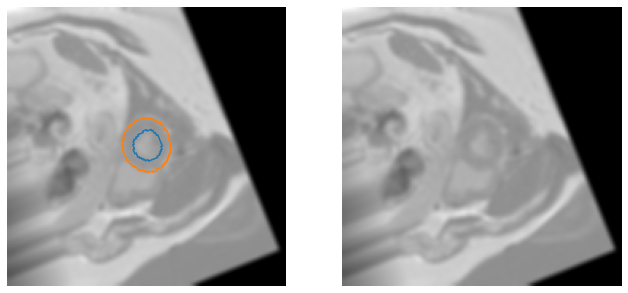

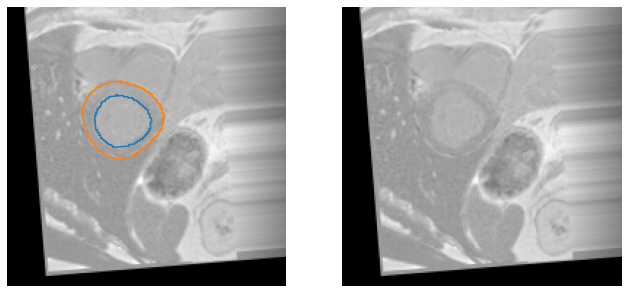

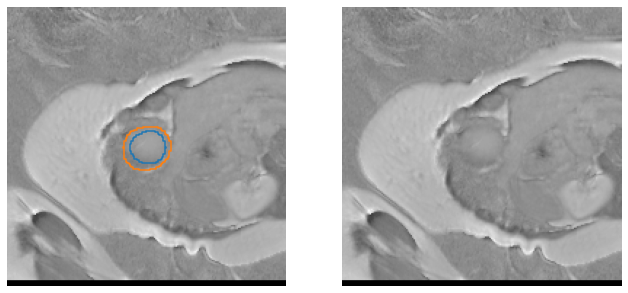

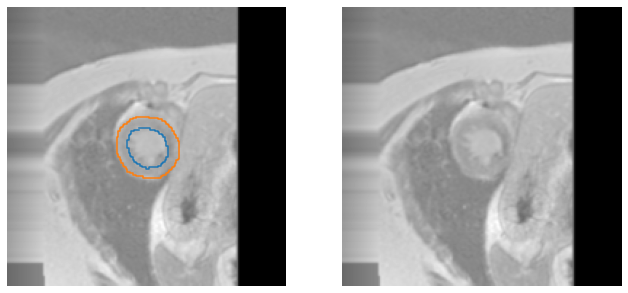

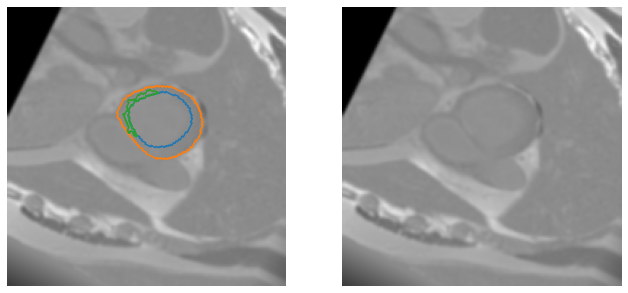

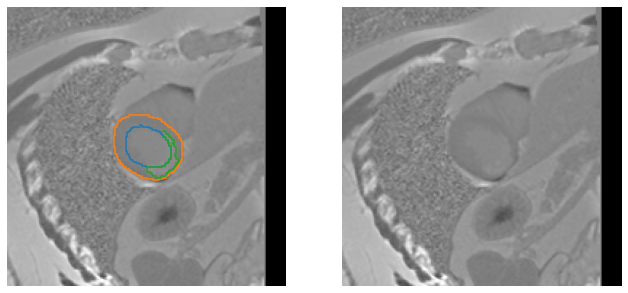

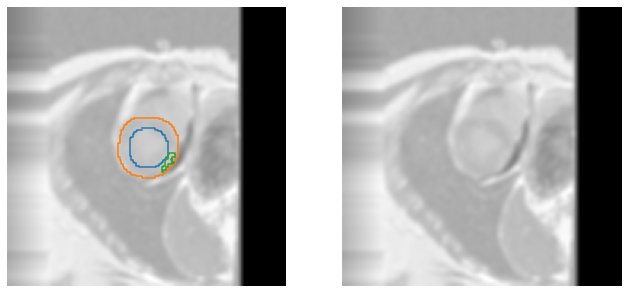

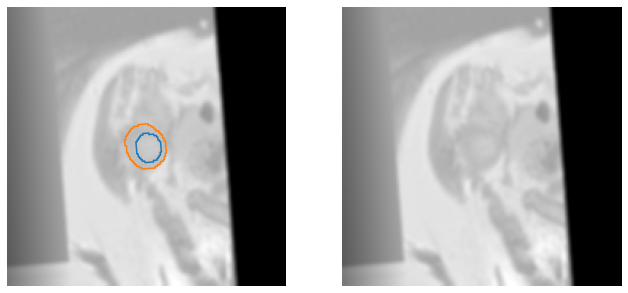

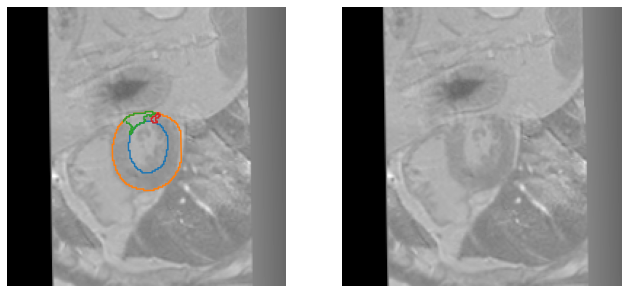

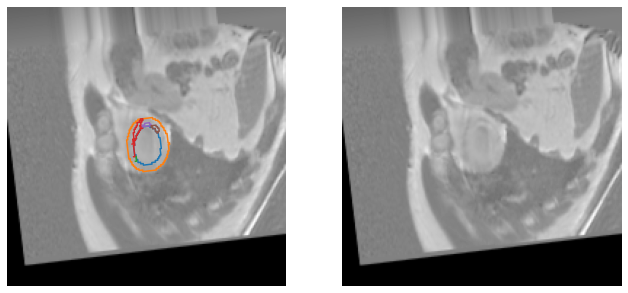

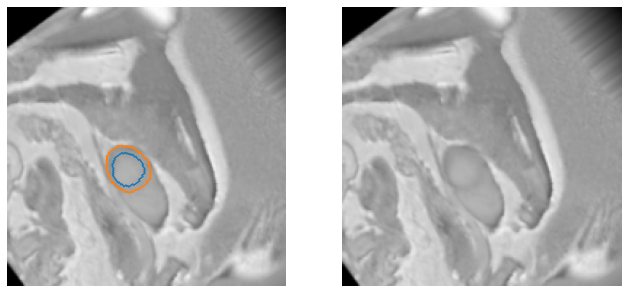

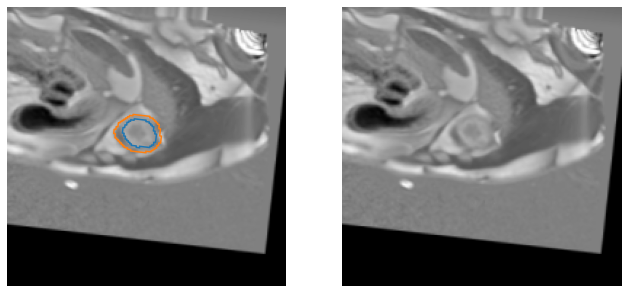

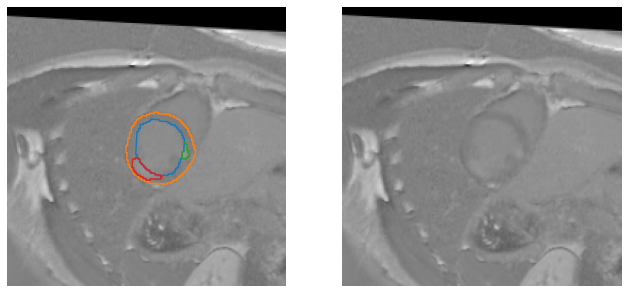

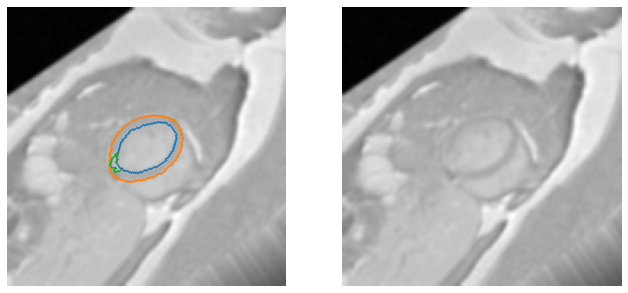

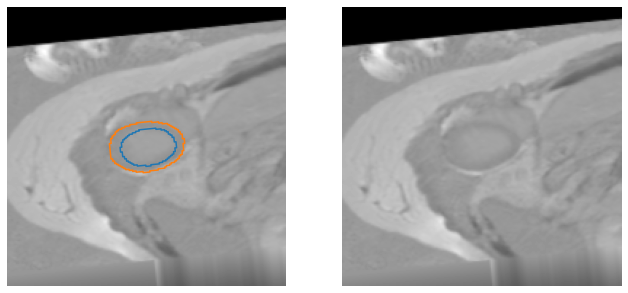

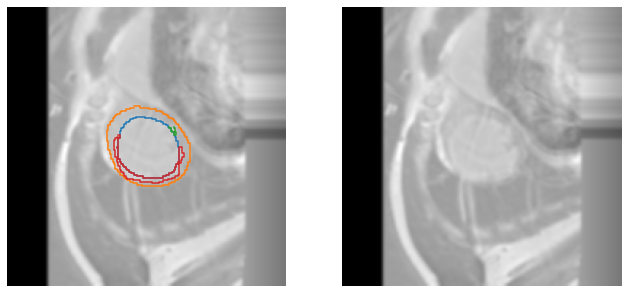

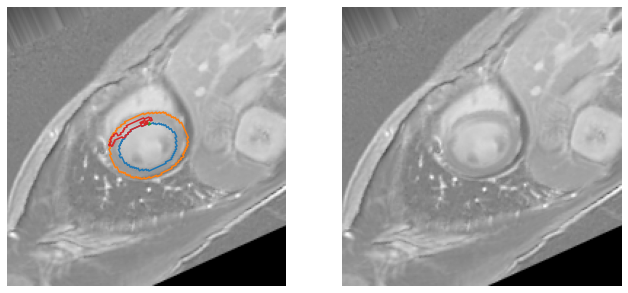

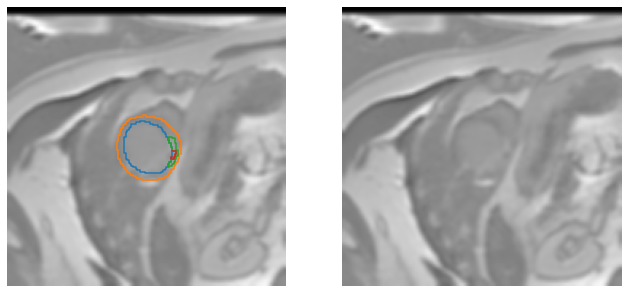

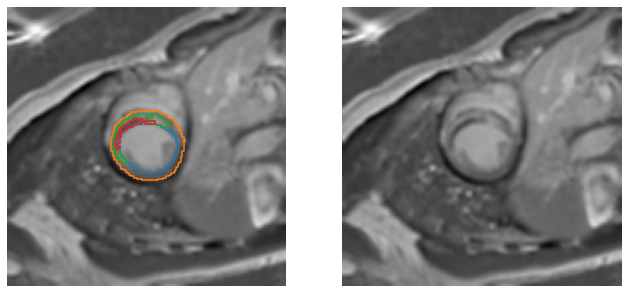

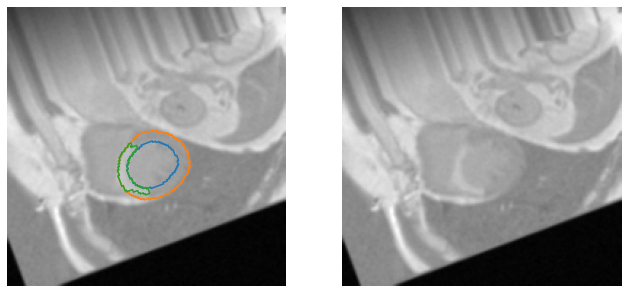

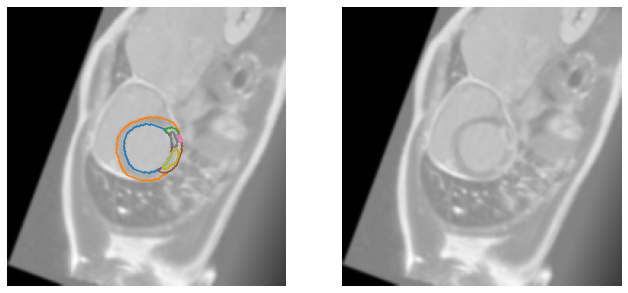

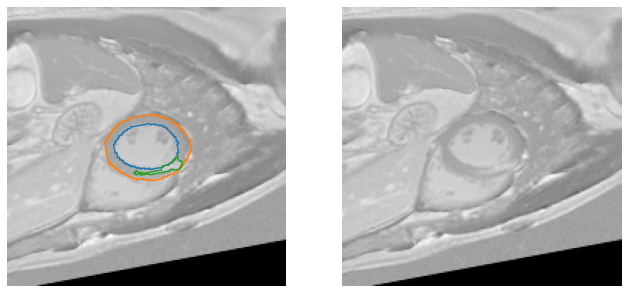

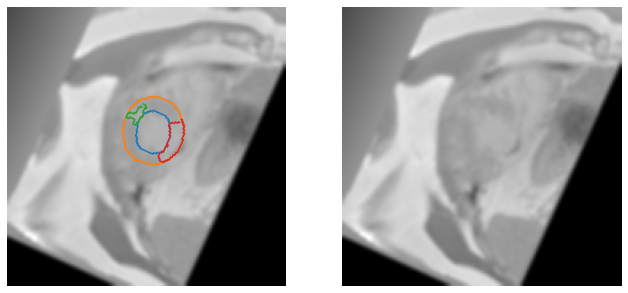

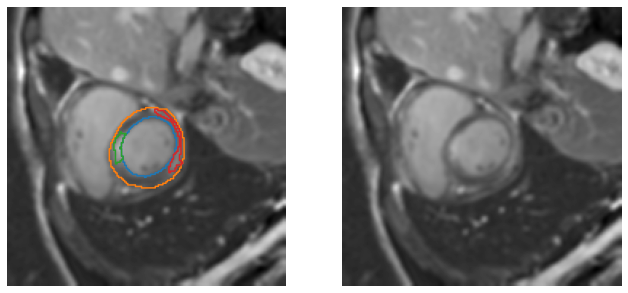

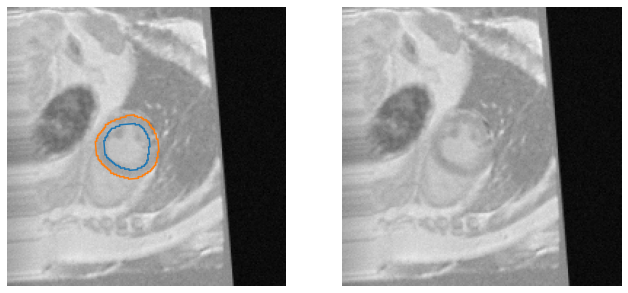

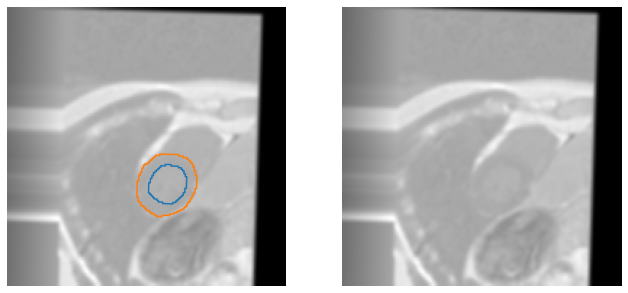

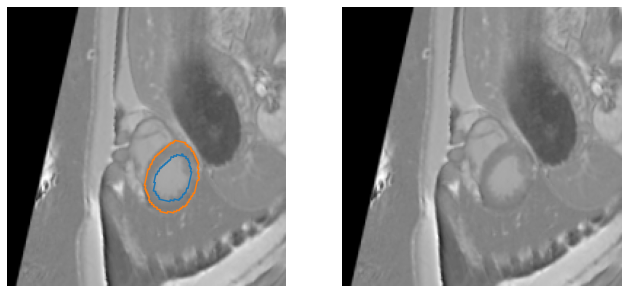

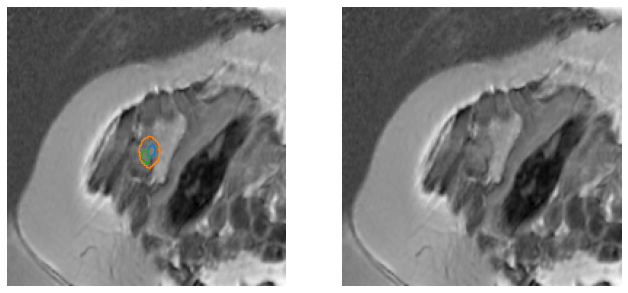

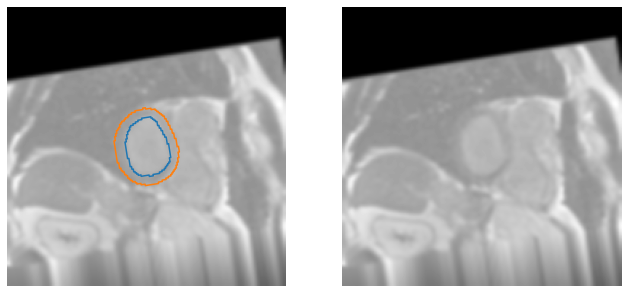

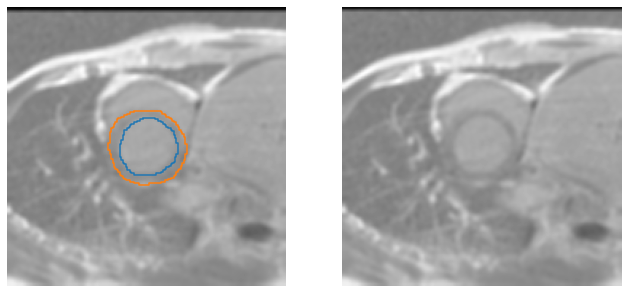

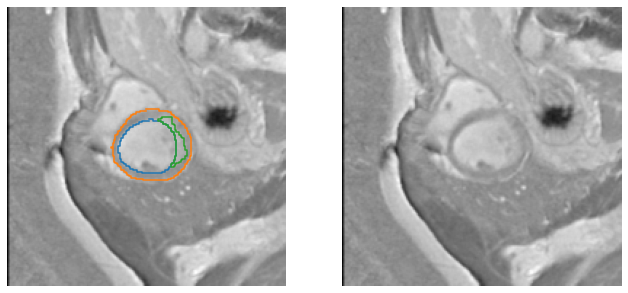

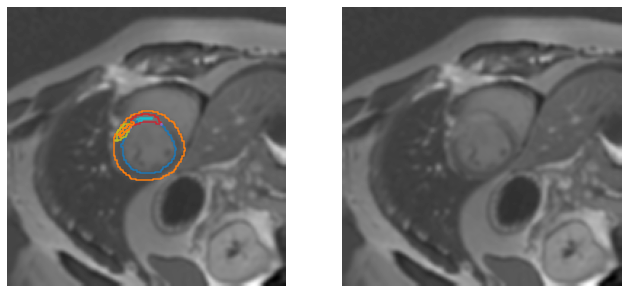

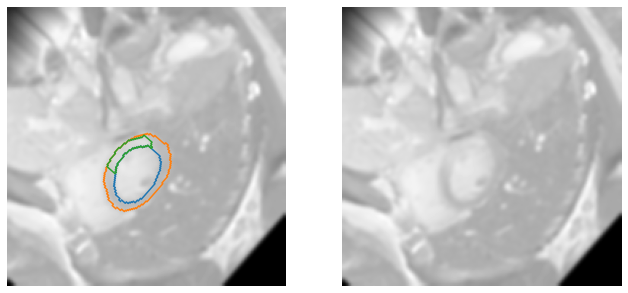

KeyboardInterrupt: 

In [171]:
for count in range(100):
    imgs, polys   = get_unaugmented_batch(batchsize=8)
    batch         = UnnormalizedBatch(images=imgs, polygons=polys)
    aug_batch     = list(aug.augment_batches(batch, background=False))
    aug_imgs      = aug_batch[0].images_aug
    aug_polys     = aug_batch[0].polygons_aug

    for i in range(len(imgs)):
        img = aug_imgs[i]
        mp  = aug_polys[i]
        fig, axes = plt.subplots(1,2,figsize=(11,7))
        for ax in axes: 
            ax.axis('off')
            ax.imshow(img, cmap='gray')
        for p in mp:
            coords = p.exterior
            axes[0].plot(coords[:,0], coords[:,1])
        plt.show()